# Assignment 5: Epipolar geometry and triangulation

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Exercise 1: Disparity

#### a) Derive teh expression for disparity which is defined as d = x1 - x2

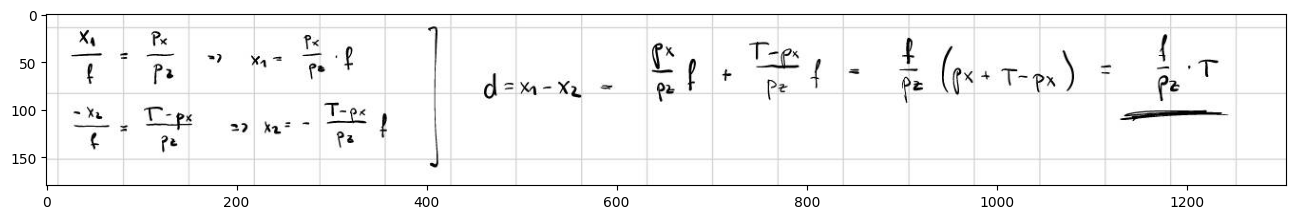

In [3]:
res = cv2.imread("1a.jpg")
fig, ax = plt.subplots(1,1,figsize=(16,5))
ax.imshow(res)


Disparity is inversely proportional to the z distance from the object - depth. When the object is close, disparity is high, when it is far, disparity is low (depth = high, disparity = low). 

#### b) Compute disparity for a range of values of p

Text(0, 0.5, 'disparity [cm]')

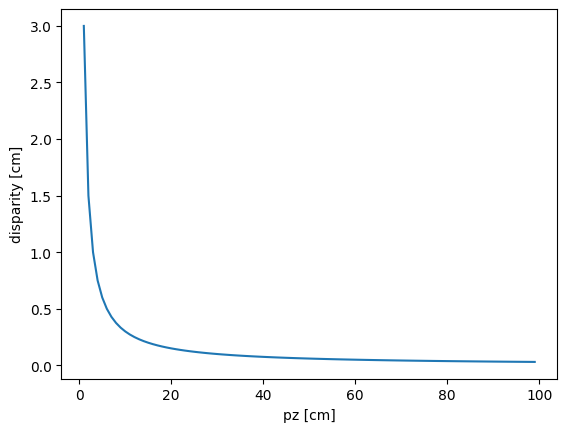

In [4]:
def disparity(z_coord, focal_length=.25, T_baseline=12):
    '''
        Computes disparity for a given z coordinate of a point, focal length and baseline are in cm
    '''
    if z_coord == 0:
        return 9999999999999999
    return focal_length * T_baseline / z_coord

disparities = []
pz = [i for i in range(1, 100)]

for p in pz:
    disparities.append(disparity(p))
    
plt.plot(pz, disparities)
plt.xlabel("pz [cm]")
plt.ylabel("disparity [cm]")    # Or px if focal length is in pixels

#### c) Bumblebee2 disparity

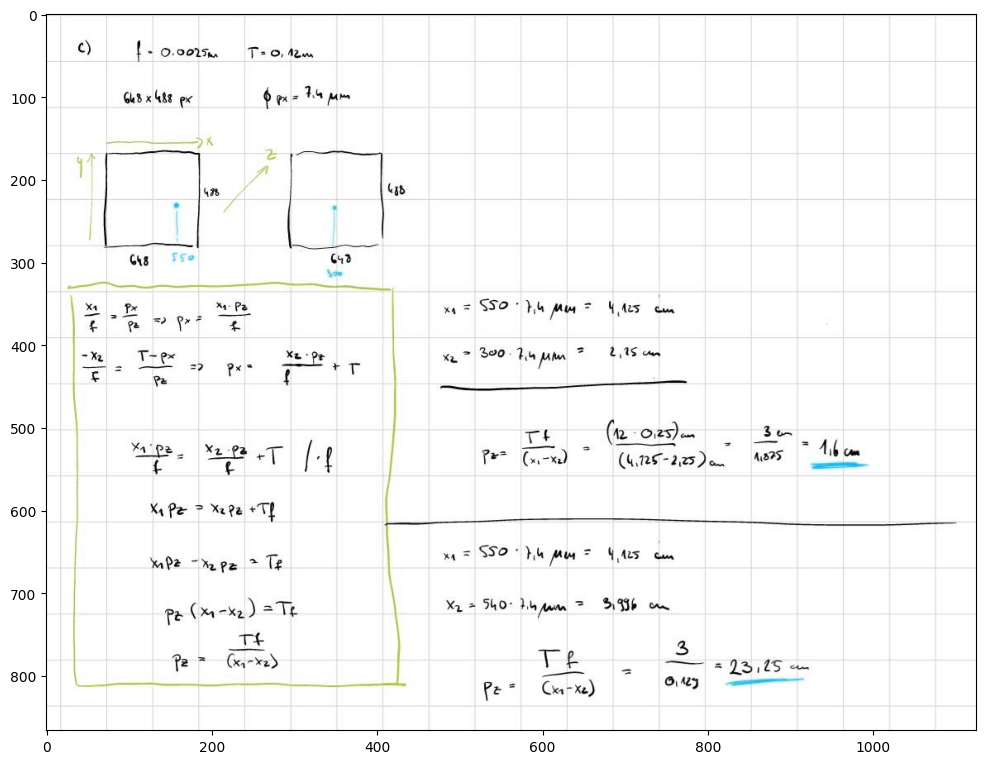

In [5]:
res = cv2.imread("1c.jpg")
fig, ax = plt.subplots(1,1,figsize=(12,12))

ax.imshow(res)

### Exercise 2: Fundamental matrix, epipoles, epipolar lines

#### a) Analytically compute the equation of the epipolar line

## TODO

#### b) Fundamental matrix estimation

In [117]:
def get_A(points1: np.ndarray, points2: np.ndarray) -> np.ndarray:
    A = []
    for p1, p2 in zip(points1, points2):
        x1, y1, z1 = p1
        x2, y2, z2 = p2
        
        row = [x1*x2, x2*y1, x2, x1*y2, y1*y2, y2, x1, y1, 1]
        A.append(row)
    A = np.array(A)
    return A
    

In [118]:
from a5_utils import *

def fundamental_matrix(points1: np.ndarray, points2: np.ndarray) -> np.ndarray:
    '''
        Computes an estimation of the fundamental matrix F, needs at least 8 pairs of points as input
    '''

    points1, T1 = normalize_points(points1)        
    points2, T2 = normalize_points(points2)        
    
    # Compute F'
    A = get_A(points1, points2)
    
    U, D, VT = np.linalg.svd(A)
    
    F = VT[-1]
    F = np.reshape(F, (3,3))

    # Enforce the constraint
    U, D, VT = np.linalg.svd(F) # This returns singular values in a vector, not a matrix

    D = np.array([[D[0], 0, 0],
                  [0, D[1], 0],
                  [0, 0, D[2]]])

    D[2,2] = 0

    F = np.matmul(U, np.matmul(D, VT))
    
    
    # F = T2.T * F' * T1
    F = np.matmul(T2.T, np.matmul(F, T1))
    return F

In [119]:
def get_epipoles(F: np.ndarray) -> np.ndarray:
    '''
        Computes both epipolar lines by SVD of the fundamental matrix
    '''
    U,D,VT = np.linalg.svd(F)
    
    e1 = VT[-1] / VT[-1, -1]
    e2 = U[-1] / U[-1, -1]
    
    return e1, e2
    

In [120]:
def get_epipolar_lines(point, epipole):
    return np.cross(point, epipole)

2


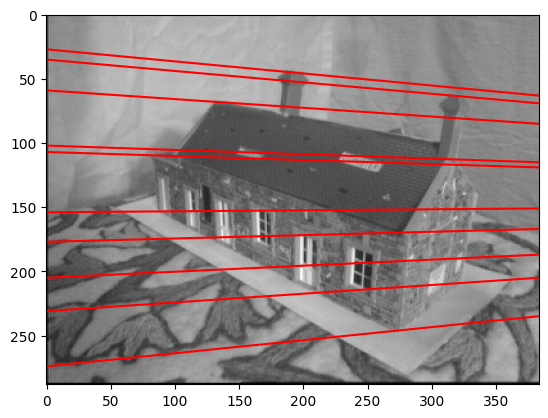

In [132]:
pts = np.loadtxt("data/epipolar/house_points.txt")
points1, points2 = [], []

for row in pts:
    points1.append((row[0], row[1]))
    points2.append((row[2], row[3]))
points1 = np.array(points1)
points2 = np.array(points2)

F = fundamental_matrix(points1, points2)
print(np.linalg.matrix_rank(F))

house1 = cv2.imread("data/epipolar/house1.jpg")
house1 = cv2.cvtColor(house1, cv2.COLOR_BGR2GRAY)

house2 = cv2.imread("data/epipolar/house2.jpg")
house2 = cv2.cvtColor(house2, cv2.COLOR_BGR2GRAY)

# Compute epipolar lines
epi1, epi2 = get_epipoles(F)


for p in points2:
    p = np.array([p[0], p[1], 1])
    
    epiline2 = np.matmul(p.T, F).T
    draw_epiline(epiline2, house2.shape[0], house2.shape[1])
    plt.imshow(house1, cmap="gray")
    


#draw_epiline(get_epipolar_lines(points1[0], epi1), house2.shape[0], house2.shape[1])
#ax[1].imshow(house2, cmap="gray")

    

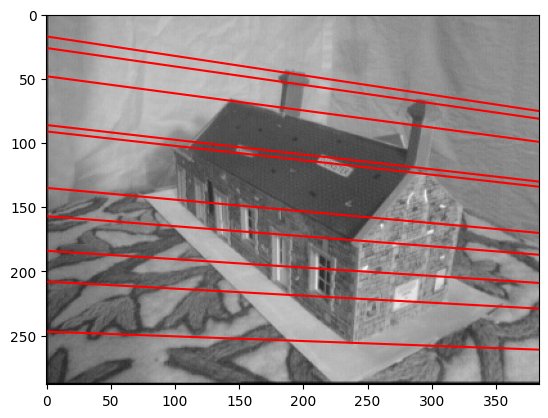

In [134]:
for p in points1:
    p = np.array([p[0], p[1], 1])
    epiline1 = np.matmul(F, p)
    draw_epiline(epiline1, house1.shape[0], house1.shape[1])
    plt.imshow(house2, cmap="gray")